In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.observations.ar_truncated_normal_observation import ARTruncatedNormalObservation
from ssm_ptc.transformations.linear import LinearTransformation
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import time

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset


In [4]:
session_data = datasets_processed[0].render_trajectories([3, 8])
traj0 = np.concatenate((session_data), axis=1)

In [239]:
# first, find part_ok index


In [ ]:
speed = np.sqrt(np.diff(traj0[:,0])**2 + np.diff(traj0[:,1])**2)


In [ ]:
# second, find out outliers

plt.hist(speed, bins=100);

In [ ]:
part_okindex = np.where(speed<15)

In [200]:
part_okindex = datasets_processed[0].allowed_index_full[3]

In [210]:
ds = datasets_processed[0]

In [214]:
rt = ds.dataset[ds.scorer].values

In [218]:
time = part_okindex[:,0:1]

In [219]:
x = part_okindex[:,1:2]*3
y = part_okindex[:,1:2]*3+1
coords = np.concatenate((x,y),axis = 1)
out = rt[time,coords]

In [223]:
part_okindex.shape

(32323, 2)

In [226]:
filtered_x,filtered_y = np.interp(ds.time_index,part_okindex[:,0],out[:,0]),np.interp(ds.time_index,part_okindex[:,0],out[:,1])

In [227]:
filtered_x.shape

(36000,)

In [5]:
data = torch.tensor(traj0[:,2:4], dtype=torch.float64)

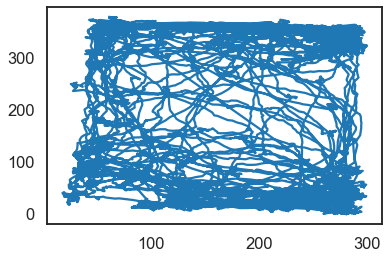

In [6]:
plt.plot(data[:,0].numpy(), data[:,1].numpy())

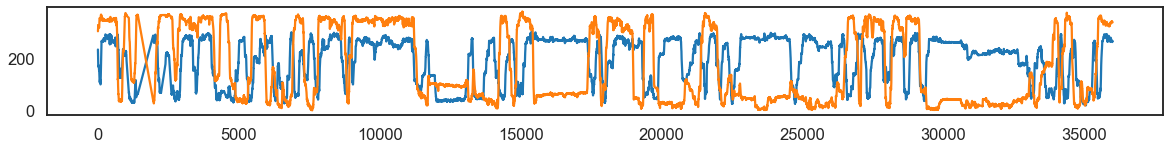

In [7]:
plt.figure(figsize=(20,2))
plt.plot(data.numpy());

In [8]:
np.min(data.numpy(), axis=0)

array([17.63016152, -1.43330193])

In [9]:
np.max(data.numpy(), axis=0)

array([299.37139297, 379.03557754])

In [98]:
arena_xmin = 10
arena_xmax = 310

arena_ymin = -10
arena_ymax = 390

In [99]:
bounds = np.array([[arena_xmin, arena_xmax], [arena_ymin, arena_ymax]])

In [12]:
bounds[0:1,].shape

(1, 2)

# first, try to fit a single dimension

In [13]:
K = 2
D = 1
T = 36000

lags = 10

bounds_1 = bounds[0:1,]

In [14]:
As = np.array([np.column_stack([np.identity(D), np.zeros((D, (lags-1) * D))]) for _ in range(K)])

In [15]:
torch.manual_seed(0)
np.random.seed(0)

tran_1 = LinearTransformation(K=K, D=D, lags=lags, As=As)
observation_1 = ARTruncatedNormalObservation(K=K, D=D, M=0, transformation=tran_1, bounds=bounds_1)

model_1 = HMM(K=K, D=D, M=0, observation=observation_1)

data_1 = data[:,0:1]

In [16]:
model_1.log_likelihood(data_1)

tensor(-3055219.1872, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

In [17]:
losses_1, optimizer_1 = model_1.fit(data_1, method='adam', num_iters=2000, lr=0.001)

iter 1990 loss 153281.77: 100%|██████████| 2000/2000 [13:09<00:00,  2.49it/s]  | 0/2000 [00:00<?, ?it/s]


In [60]:
losses_2, _ = model_1.fit(data_1, optimizer=optimizer_1, num_iters=2000)

iter 1990 loss 107156.94: 100%|██████████| 2000/2000 [10:18<00:00,  2.99it/s] | 0/2000 [00:00<?, ?it/s]


In [74]:
losses_3, _ = model_1.fit(data_1, optimizer=optimizer_1, num_iters=2000)

iter 1990 loss 92924.61: 100%|██████████| 2000/2000 [10:07<00:00,  3.45it/s]  | 0/2000 [00:00<?, ?it/s]


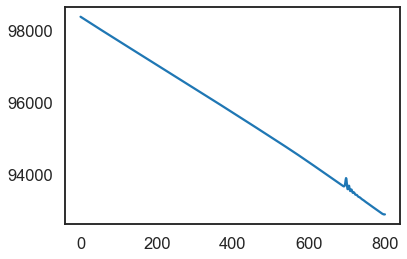

In [75]:
plt.plot(losses_3[1200:])

In [76]:
# inference
z_1 = model_1.most_likely_states(data_1)

In [77]:
x_predict_arr_1 = k_step_prediction(model_1, z_1, data_1)

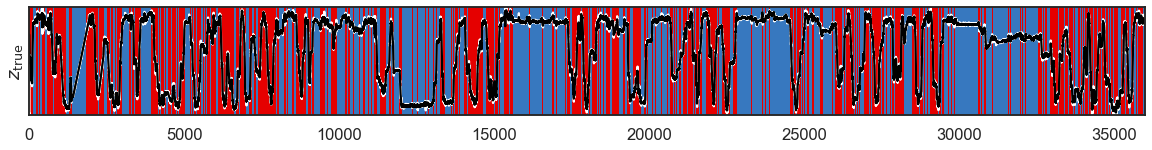

In [78]:
plot_range = np.arange(0, 36000)

plt.figure(figsize=(20,2))
plt.imshow(z_1[None,plot_range[0]:plot_range[-1]], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(plot_range[0], plot_range[-1], arena_xmin, arena_xmax))
plt.xlim(plot_range[0], plot_range[-1])
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

#plt.figure(figsize=(20,2))
plt.plot(plot_range, x_predict_arr_1[plot_range[0]:plot_range[-1]+1], color='white')
plt.plot(plot_range, data_1[plot_range[0] : plot_range[-1]+1].numpy(), color='black');

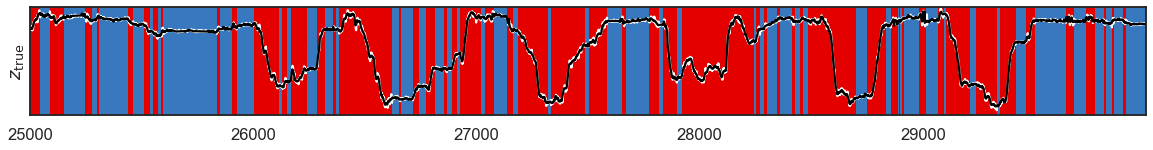

In [84]:
plot_range = np.arange(25000, 30000)

plt.figure(figsize=(20,2))
plt.imshow(z_1[None,plot_range[0]:plot_range[-1]], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(plot_range[0], plot_range[-1], arena_xmin, arena_xmax))
plt.xlim(plot_range[0], plot_range[-1])
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

#plt.figure(figsize=(20,2))
plt.plot(plot_range, x_predict_arr_1[plot_range[0]:plot_range[-1]+1], color='white')
plt.plot(plot_range, data_1[plot_range[0] : plot_range[-1]+1].numpy(), color='black');

It seems like that k=0 corresponds to upward movement.

In [80]:
[sum(z_1 == k) for k in range(K)]

[17776, 18224]

In [81]:
sample_z1, sample_x1 = model_1.sample(T)

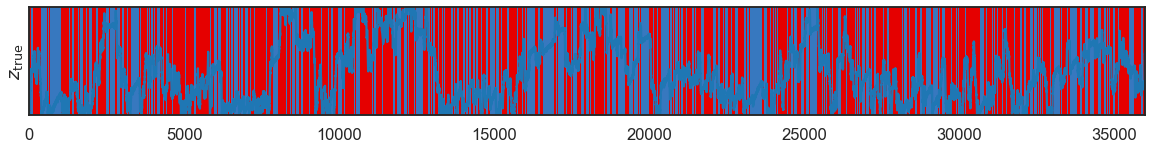

In [86]:
plt.figure(figsize=(20,2))

plt.imshow(sample_z1[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(0, T, arena_xmin, arena_xmax))
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.plot(sample_x1)
#plt.plot(data_1.numpy())

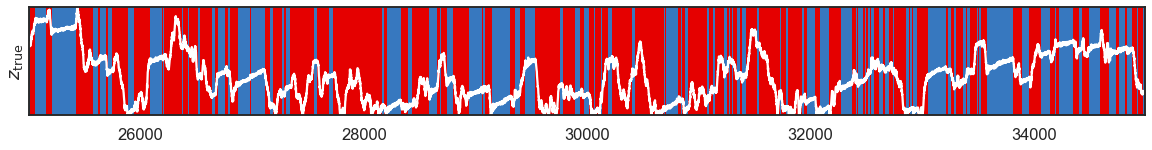

In [117]:
plot_range = np.arange(25000, 35000)

plt.figure(figsize=(20,2))
plt.imshow(sample_z1[None,plot_range[0]:plot_range[-1]], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(plot_range[0], plot_range[-1], arena_xmin, arena_xmax))
plt.xlim(plot_range[0], plot_range[-1])
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

#plt.figure(figsize=(20,2))
plt.plot(plot_range, sample_x1[plot_range[0]:plot_range[-1]+1], color='white');

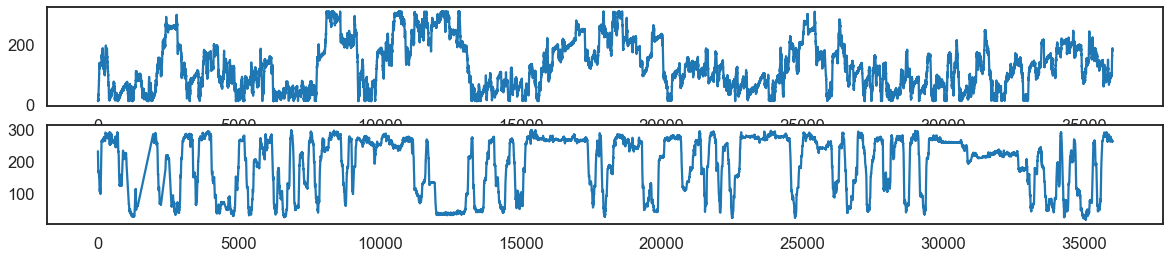

In [85]:
plt.figure(figsize=(20,4))

plt.subplot(2,1,1)
plt.plot(sample_x1)

plt.subplot(2,1,2)
plt.plot(data_1.numpy())

Now, check the speed.

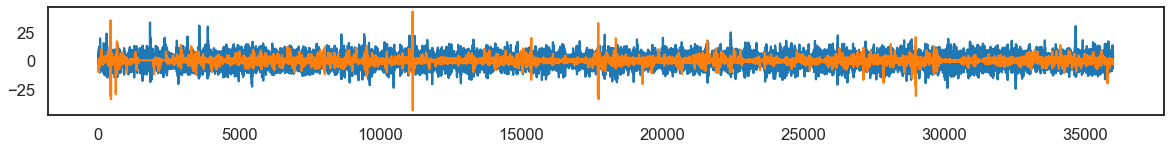

In [87]:
plt.figure(figsize=(20,2))
plt.plot(np.diff(sample_x1, axis=0))
plt.plot(np.diff(data_1.numpy(), axis=0))

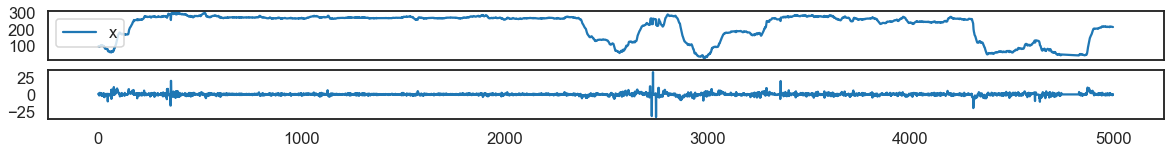

In [88]:
plt.figure(figsize=(20,2))
plt.subplot(2,1,1)
plt.plot(data_1.numpy()[15000:20000], label='x')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.diff(data_1.numpy()[15000:20000], axis=0))

Even in darting, the speed is "low". Darting just indicates moving in a direction continuously.

Now, check the space occupancy.

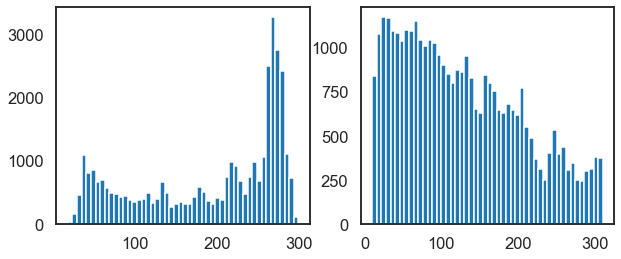

In [89]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(data_1.numpy(), bins=50);
plt.subplot(1,2,2)
plt.hist(sample_x1, bins=50);


Increasing lags does not seem to help learning the inertia.

There are somthing to dive in in terms of space occupancy even in the 1D case.

# Fit 2d trajectory of a single animal

In [92]:
data.shape

torch.Size([36000, 2])

In [100]:
bounds = np.array([[arena_xmin, arena_xmax], [arena_ymin, arena_ymax]])

In [113]:
bounds.shape

(2, 2)

In [101]:
bounds

array([[ 10, 310],
       [-10, 390]])

In [102]:
torch.max(data, dim=0)[0]

tensor([299.3714, 379.0356], dtype=torch.float64)

In [103]:
torch.min(data, dim=0)[0]

tensor([17.6302, -1.4333], dtype=torch.float64)

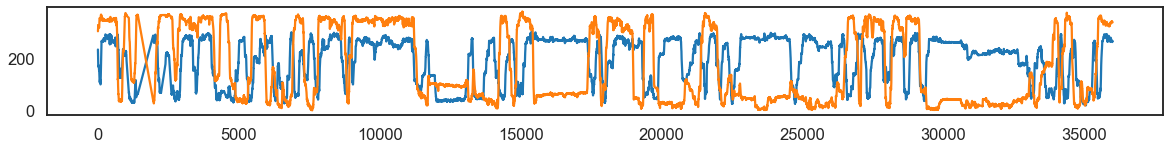

In [108]:
plt.figure(figsize=(20,2))
plt.plot(data[:,0].numpy())
plt.plot(data[:,1].numpy());

In [179]:
torch.manual_seed(10)
np.random.seed(10)

K = 2
D = 2
T = 36000

As = np.array([np.column_stack([np.identity(D), np.zeros((D, (lags-1) * D))]) for _ in range(K)])

In [180]:
tran = LinearTransformation(K=K, D=D, lags=lags, As=As)
observation = ARTruncatedNormalObservation(K=K, D=D, M=0, transformation=tran, bounds=bounds)

model = HMM(K=K, D=D, M=0, observation=observation)

In [181]:
ls_1, opt_1 = model.fit(data, num_iters=5000, lr=0.001);

iter 4990 loss 220505.95: 100%|██████████| 5000/5000 [26:23<00:00,  3.04it/s]  | 0/5000 [00:00<?, ?it/s]


In [238]:
ls_2, _ = model.fit(data, optimizer=opt_1, num_iters=3000);

iter 2990 loss 212466.41: 100%|██████████| 3000/3000 [14:51<00:00,  3.40it/s] | 0/3000 [00:00<?, ?it/s]


In [258]:
ls_3, opt_2 = model.fit(data, num_iters=3000, lr=0.0005);

iter 2990 loss 210988.23: 100%|██████████| 3000/3000 [16:09<00:00,  3.25it/s] | 0/3000 [00:00<?, ?it/s]


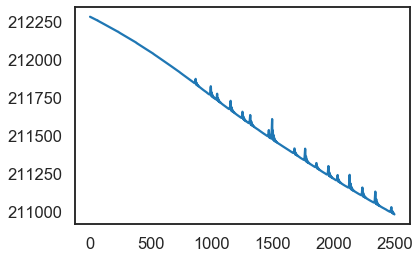

In [260]:
plt.plot(ls_3[500:])

### prediction

In [261]:
# inference
z = model.most_likely_states(data)

In [262]:
x_predict_arr = k_step_prediction(model, z, data)

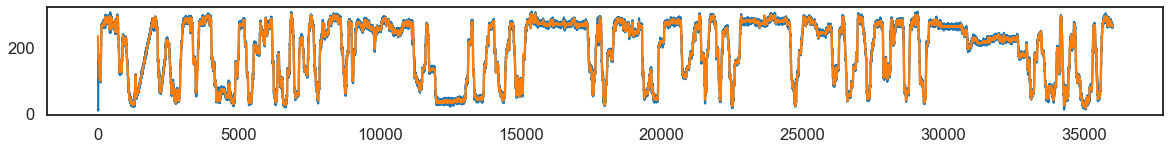

In [263]:
plt.figure(figsize=(20,2))
plt.plot(plot_range, x_predict_arr[plot_range[0]:plot_range[-1]+1, 0])
plt.plot(plot_range, data[plot_range[0] : plot_range[-1]+1, 0].numpy());

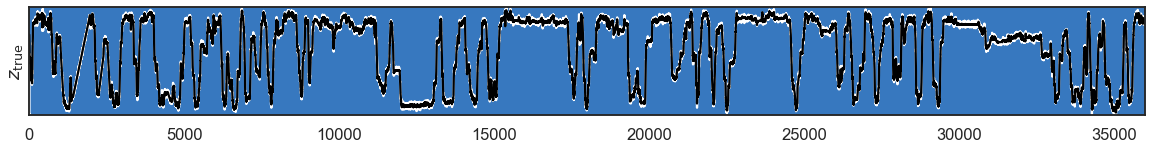

In [264]:
plot_range = np.arange(0, 36000)

plt.figure(figsize=(20,2))
plt.imshow(z[None,plot_range[0]:plot_range[-1]], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(plot_range[0], plot_range[-1], arena_xmin, arena_xmax))
plt.xlim(plot_range[0], plot_range[-1])
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

#plt.figure(figsize=(20,2))
plt.plot(plot_range, x_predict_arr[plot_range[0]:plot_range[-1]+1, 0], color='white')
plt.plot(plot_range, data[plot_range[0] : plot_range[-1]+1, 0].numpy(), color='black');

In [265]:
[sum(z==k) for k in range(K)]

[35975, 25]

### samples

In [266]:
sample_z, sample_x = model.sample(T)

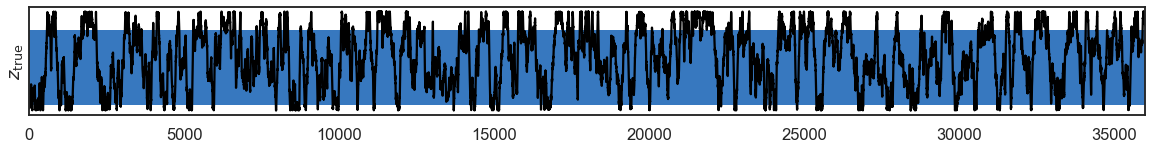

In [267]:
plt.figure(figsize=(20,2))

plt.imshow(sample_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(0, T, arena_xmin, arena_xmax))
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

#plt.plot(sample_x[:,0], color='white')
plt.plot(sample_x[:,1], color='black')
#plt.plot(data_1.numpy())

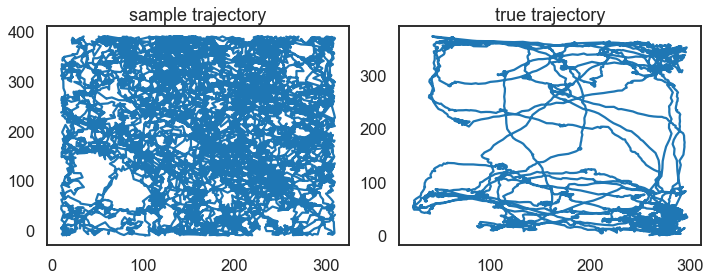

In [278]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(sample_x[20000:30000,0], sample_x[20000:30000,1]);
plt.title("sample trajectory")

plt.subplot(1,2,2)
plt.plot(data[20000:30000,0].numpy(), data[20000:30000,1].numpy());
plt.title("true trajectory")

plt.tight_layout()

Text(0.5, 1.0, 'true trajectory')

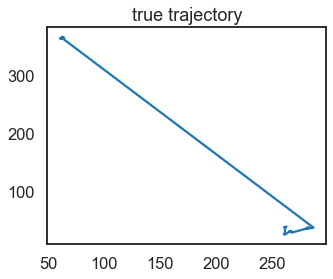

In [269]:
plt.figure(figsize=(5,4))

plt.plot(data[1400:2000,0].numpy(), data[1400:2000,1].numpy());
plt.title("true trajectory")

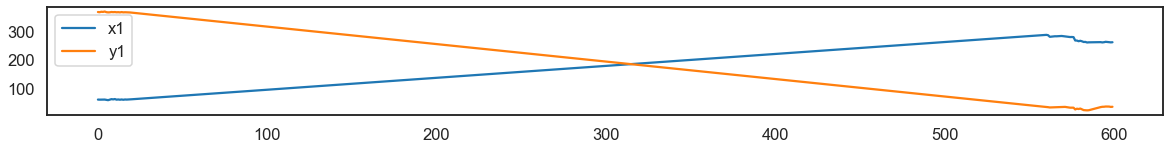

In [270]:
plt.figure(figsize=(20,2))

plt.plot(data[1400:2000,0].numpy(), label='x1')
plt.plot(data[1400:2000,1].numpy(), label='y1')
plt.legend();

check speed

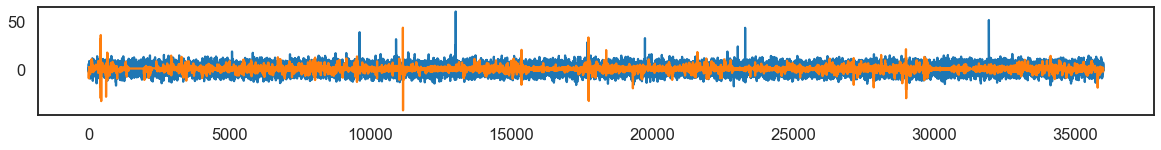

In [271]:
plt.figure(figsize=(20,2))
plt.plot(np.diff(sample_x[:,0]))
plt.plot(np.diff(data[:,0].numpy()))

check space occupancy

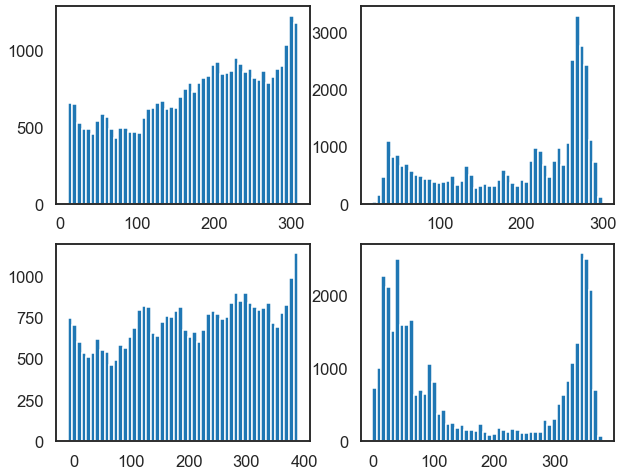

In [272]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.hist(sample_x[:,0], bins=50);
plt.subplot(2,2,2)
plt.hist(data[:,0].numpy(), bins=50);
plt.subplot(2,2,3)
plt.hist(sample_x[:,1], bins=50);
plt.subplot(2,2,4)
plt.hist(data[:,1].numpy(), bins=50);
